# Exercise 10: Image stitching

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color
import skimage

In [32]:
def Pi(points):
    if points.ndim == 2:
        n,p = points.shape
        new_points = np.vstack((points, np.ones(p)))
    elif points.ndim == 1:
        n = len(points)
        new_points = np.append(points, [1])
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

### Exercise 10.1

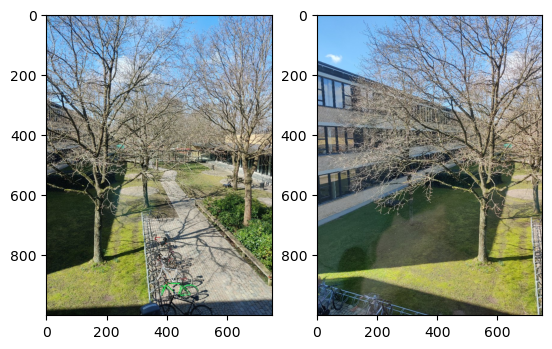

(1000, 750, 3) (1000, 750, 3)


In [33]:
im1 = cv2.imread('im1.jpg')[:,:,::-1]
im2 = cv2.imread('im2.jpg')[:,:,::-1]

fig, ax = plt.subplots(1,2)
ax[0].imshow(im1)
ax[1].imshow(im2)
plt.show()

print(im1.shape, im2.shape)

In [34]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

# BFMatcher with default params
bf = cv2.BFMatcher_create(crossCheck=True) # cross checking
matches = bf.knnMatch(des1, des2, k=1)

# get non empty tuples
good_matches = []  
for m in matches:
    if m:
        good_matches.append(m[0])
        
# Sort them in the order of their distance
#good_matches = sorted(good_matches, key = lambda x:x.distance)
        
# Sort them in the order of their distance. (get the best matches first)
#good_matches = sorted(good_matches, key = lambda x:x[0].distance)
    
# Find coordinates
pts_im1 = [kp1[m.queryIdx].pt for m in good_matches]
pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = [kp2[m.trainIdx].pt for m in good_matches]
pts_im2 = np.array(pts_im2, dtype=np.float32).T

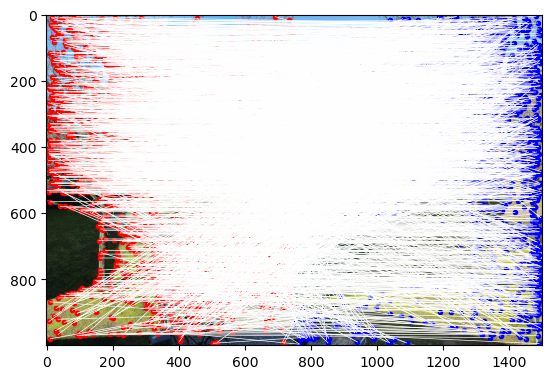

In [35]:
r1,c1,d1 = im1.shape
r2,c2,d2 = im2.shape
n_row = np.maximum(r1, r2)
n_col = c1 + c2
im_comp = np.zeros((n_row,n_col,3))
im_comp[:r1,:c1,:d1] = im1
im_comp[:r2,c1:(c1+c2),:d2] = im2
im_comp = im_comp.astype('uint8')

# show every sift
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(pts_im1[0],pts_im1[1],'.r')
ax.plot(pts_im2[0]+c1,pts_im2[1],'.b')
ax.plot(np.c_[pts_im1[0],pts_im2[0]+c1].T,np.c_[pts_im1[1],pts_im2[1]].T,'w',linewidth = 0.5)

plt.show()

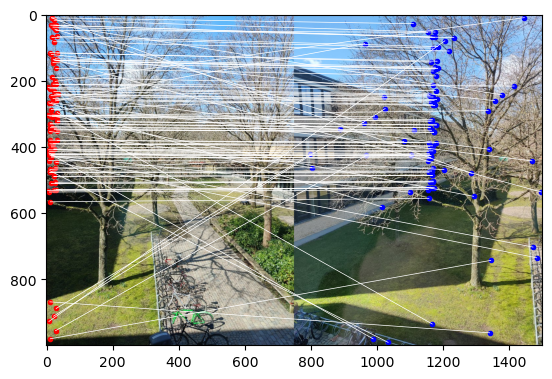

In [36]:
# show few sift
n = 100
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(pts_im1[0][0:n],pts_im1[1][0:n],'.r')
ax.plot(pts_im2[0][0:n]+c1,pts_im2[1][0:n],'.b')
ax.plot(np.c_[pts_im1[0][0:n],pts_im2[0][0:n]+c1].T,np.c_[pts_im1[1][0:n],pts_im2[1][0:n]].T,'w',linewidth = 0.5)

plt.show()

### Exercise 10.2

The minimum number of point correspondences needed to estimate a homography is four. A homography
has 9 parameters, subtracting one for over all scale, we need 8 constraints – i.e. H and s   H represent the
same transformation, for any non-zero scalar s. Considering (2.41), it is seen that even though bTi
is a 3   9 it
only/maximally has rank two, since [q1i]  is a rank two matrix. Thus 8=2 = 4 bTi
are needed, equivalent to
four point correspondences.

In [37]:
## RANSAC algo (week9 with minor adaptations)

def line(q1, q2):
    l = np.cross(q1, q2)
    l = l/np.sqrt(l[0]**2+l[1]**2)
    return l

def getinliers(Q, l, tau):
    Qh = Pi(Q)
    inliers = []
    outliers = []
    for i in range(Qh.shape[1]):
        d = abs(np.dot(l, Qh[:,i]))
        if d <= tau:
            inliers.append(Q[:,i])
        else:
            outliers.append(Q[:,i])
    inliers = np.array(inliers)
    outliers = np.array(outliers)
    return inliers, outliers

def consensus(Q, l, tau):
    inliers, outliers = getinliers(Q, l, tau)
    return len(inliers)

def draw(Q):
    Q = np.random.permutation(Q.T).T
    return Q[:,0], Q[:,1]

def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

def RANSAC(Q, tau):
    p = 0.99
    m = Q.shape[1]
    nmax_inliers = 0
    lfit = 0
    N = 0
    Nhat = 10
    while N <= Nhat:
        q1, q2 = draw(Q)
        l = line(Pi(q1), Pi(q2))
        n_inliers = consensus(Q, l, tau)
        if n_inliers > nmax_inliers:
            nmax_inliers = n_inliers
            lfit = l
        epshat = 1 - nmax_inliers/m
        Nhat = np.log(1-p)/np.log(1-(1-epshat)**2)
        N += 1
    inliers, outliers = getinliers(Q, lfit, tau)
    lfit = pca_line(inliers.T)
    return lfit, N

In [38]:
## Homographie estimation (week2)

def normalize2d(p):
    mu = np.mean(p,axis=1)
    sigma = np.std(p,axis=1)
    Tinv = np.array([[sigma[0],0,mu[0]],
                     [0,sigma[1],mu[1]],
                     [0,0,1]])
    T = np.linalg.inv(Tinv)
    return T

def hest(q1,q2,normalize = False):
    n,p = q1.shape
    
    if normalize == True:
        T1 = normalize2d(q1)
        T2 = normalize2d(q2)
        q1 = T1 @ Pi(q1)
        q2 = T2 @ Pi(q2)
    else:
        q1 = Pi(q1)
        q2 = Pi(q2)
    
    B = np.zeros((3*p,9))
    for i in range(p):
        M = np.array([[0,-1,q1[1,i]],
                      [1,0,-q1[0,i]],
                      [-q1[1,i],q1[0,i],0]])
        Bi = np.kron(q2[:,i], M)
        B[i*3:(i+1)*3,:] = Bi
        
    H = np.linalg.svd(B)[2][-1,:].reshape(3,3).T
    
    if normalize == True:
        H = np.linalg.inv(T1) @ H @ T2
        
    return H

def DistanceHapprox(H, p1, p2):
    a = PiInv(H@p2) - PiInv(p1)
    b = PiInv(np.linalg.inv(H)@p1) - PiInv(p2)
    d = a[0]**2 + a[1]**2 + b[0]**2 + b[1]**2
    return d

In [42]:

def hestRANSAC(good_matches, kp1, kp2, pts_im1, pts_im2, it=200,sigma=3):
    thres = 3.84 * sigma**2 # cf slide
    nb_inliers_max = 0
    
    #### repeat 200 times 
    for k in range(it):
        
        p1inliers = [[],[]]
        p2inliers = [[],[]]

        ## sampled 4 points randomly 
        sample = np.random.choice(good_matches, 4, replace=False)

        # Find coordinates
        p1 = [kp1[m.queryIdx].pt for m in sample]
        p1 = np.array(p1, dtype=np.float32).T
        p2 = [kp2[m.trainIdx].pt for m in sample]
        p2 = np.array(p2, dtype=np.float32).T

        ## find F matrix 
        H = hest(p1,p2, False)

        # find inliers
        for i in range(pts_im1.shape[1]):
            pi1 = Pi(pts_im1[:,i])
            pi1.shape += (1,)
            pi2 = Pi(pts_im2[:,i])
            pi2.shape += (1,)
            d = DistanceHapprox(H, pi1, pi2)
            if d < thres :
                p1inliers[0].append(pi1[0][0])
                p1inliers[1].append(pi1[1][0])
                p2inliers[0].append(pi2[0][0])
                p2inliers[1].append(pi2[1][0])
        
        p1inliers = np.array(p1inliers)
        p2inliers = np.array(p2inliers)
    
        nb_inliers = p1inliers.shape[1]
    
        if nb_inliers > nb_inliers_max:
            nb_inliers_max = nb_inliers
            p1inliers_max = p1inliers
            p2inliers_max = p2inliers
    
    

    Ffinal = hest(p1inliers_max,p2inliers_max)
    return Ffinal, p1inliers_max, p2inliers_max

In [43]:
Ffinal, p1inliers, p2inliers = hestRANSAC(good_matches, kp1, kp2, pts_im1, pts_im2)

In [44]:
p1inliers.shape

(2, 446)

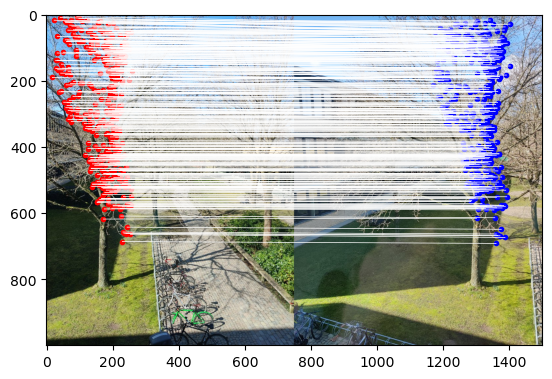

In [49]:
# show inliers
n = 400
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(p1inliers[0,:n], p1inliers[1,:n],'.r')
ax.plot(p2inliers[0,:n]+c1, p2inliers[1,:n],'.b')
ax.plot(np.c_[p1inliers[0,:n],p2inliers[0,:n]+c1].T, np.c_[p1inliers[1,:n],p2inliers[1,:n]].T, 'w', linewidth = 0.5)

plt.show()

In [50]:
p1inliers.shape # ok if around 1000 for this image

(2, 446)

### Exercise 10.3

In [51]:
def estHomographyRANSAC(kp1, des1, kp2, des2, sigma=3, it=200):
    
    # BFMatcher with default params
    bf = cv2.BFMatcher_create(crossCheck=True) # cross checking
    matches = bf.knnMatch(des1, des2, k=1)

    # get non empty tuples
    good_matches = []  
    for m in matches:
        if m:
            good_matches.append(m[0])

    # Sort them in the order of their distance. (get the best matches first)
    #good_matches = sorted(good_matches, key = lambda x:x.distance)

    # Find coordinates
    pts_im1 = [kp1[m.queryIdx].pt for m in good_matches]
    pts_im1 = np.array(pts_im1, dtype=np.float32).T
    pts_im2 = [kp2[m.trainIdx].pt for m in good_matches]
    pts_im2 = np.array(pts_im2, dtype=np.float32).T
    
    thres = 3.84 * sigma**2 # cf slide
    nb_inliers_max = 0
        
    #### repeat 200 times 
    for k in range(it):
        
        p1inliers = [[],[]]
        p2inliers = [[],[]]

        ## sampled 4 points randomly 
        sample = np.random.choice(good_matches, 4, replace=False)

        # Find coordinates
        p1 = [kp1[m.queryIdx].pt for m in sample]
        p1 = np.array(p1, dtype=np.float32).T
        p2 = [kp2[m.trainIdx].pt for m in sample]
        p2 = np.array(p2, dtype=np.float32).T

        ## find F matrix 
        H = hest(p1,p2, False)

        # find inliers
        for i in range(pts_im1.shape[1]):
            pi1 = Pi(pts_im1[:,i])
            pi1.shape += (1,)
            pi2 = Pi(pts_im2[:,i])
            pi2.shape += (1,)
            d = DistanceHapprox(H, pi1, pi2)
            if d < thres :
                p1inliers[0].append(pi1[0][0])
                p1inliers[1].append(pi1[1][0])
                p2inliers[0].append(pi2[0][0])
                p2inliers[1].append(pi2[1][0])

        p1inliers = np.array(p1inliers)
        p2inliers = np.array(p2inliers)
    
        nb_inliers = p1inliers.shape[1]
    
        if nb_inliers > nb_inliers_max:
            nb_inliers_max = nb_inliers
            p1inliers_max = p1inliers
            p2inliers_max = p2inliers
    
    

    Hfinal = hest(p1inliers_max,p2inliers_max)
    return Hfinal, p1inliers_max, p2inliers_max


In [52]:
H, p1inliers_max, p2inliers_max = estHomographyRANSAC(kp1, des1, kp2, des2)

In [53]:
H

array([[ 2.31515711e-03,  3.82453834e-05, -9.41605067e-01],
       [ 6.02897706e-04,  2.09715035e-03, -3.36701470e-01],
       [ 1.28642129e-06,  3.45417204e-10,  1.37665007e-03]])

In [60]:
p2inliers_max.shape # should be around 1000

(2, 942)

### Exercise 10.4

In [54]:
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(mask, H, outSize)
    return imWarp, maskWarp

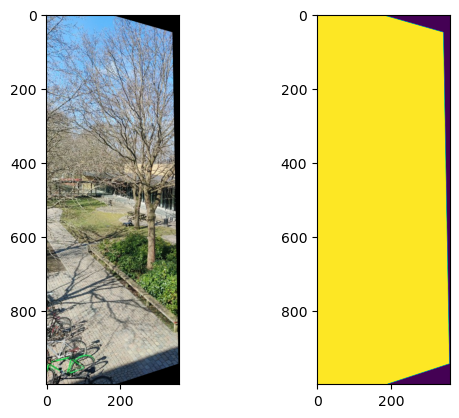

In [103]:
xRange = [0, im1.shape[1]-390]
yRange = [0, im1.shape[0]]
imWarp, maskWarp = warpImage(im1, H, xRange, yRange)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imWarp)
ax[1].imshow(maskWarp)
plt.show()

In [104]:
imWarp.shape

(1000, 360, 3)

In [105]:
im2.shape

(1000, 750, 3)

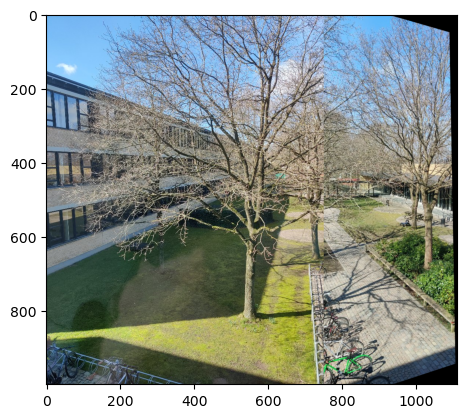

In [106]:
n,mwarp, c = imWarp.shape
n,m2, c = im2.shape

IM = np.zeros((n,mwarp+m2,c))
IM[:,:m2,:] = im2
IM[:,m2:,:] = imWarp
IM = IM.astype('uint8')
plt.imshow(IM)

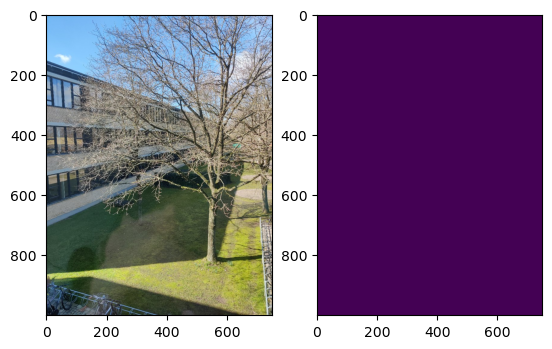

In [71]:
xRange = [0, im1.shape[1]]
yRange = [0, im1.shape[0]]
imWarp, maskWarp = warpImage(im2, np.eye(3), xRange, yRange)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imWarp)
ax[1].imshow(maskWarp)
plt.show()

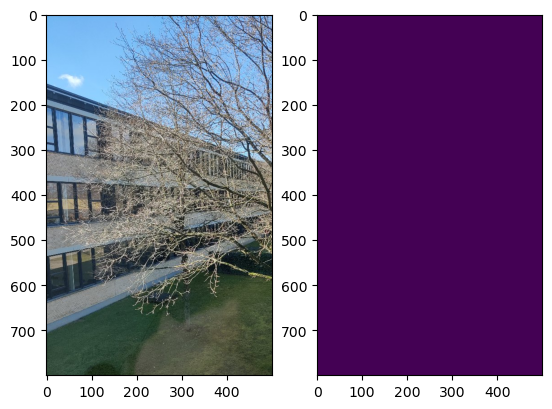

In [19]:
xRange = [0, 500]
yRange = [0, 800]
imWarp, maskWarp = warpImage(im2, np.eye(3), xRange, yRange)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imWarp)
ax[1].imshow(maskWarp)
plt.show()

### Exercise 10.5

In [25]:
help(cv2.warpPerspective)

Help on built-in function warpPerspective:

warpPerspective(...)
    warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst
    .   @brief Applies a perspective transformation to an image.
    .   
    .   The function warpPerspective transforms the source image using the specified matrix:
    .   
    .   \f[\texttt{dst} (x,y) =  \texttt{src} \left ( \frac{M_{11} x + M_{12} y + M_{13}}{M_{31} x + M_{32} y + M_{33}} ,
    .        \frac{M_{21} x + M_{22} y + M_{23}}{M_{31} x + M_{32} y + M_{33}} \right )\f]
    .   
    .   when the flag #WARP_INVERSE_MAP is set. Otherwise, the transformation is first inverted with invert
    .   and then put in the formula above instead of M. The function cannot operate in-place.
    .   
    .   @param src input image.
    .   @param dst output image that has the size dsize and the same type as src .
    .   @param M \f$3\times 3\f$ transformation matrix.
    .   @param dsize size of the output image.
    .   @param flags 